In [2]:
#!pip install sympy
#!pip install control
#!pip install tbcontrol
#!pip install ipywidgets
#!pip install perlin_noise
#!pip install numpy
#!pip install matplotlib ipympl jupyter

In [3]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib widget
import control as ct
import sympy as sp

import ipywidgets as widgets
from ipywidgets import interactive

from scipy.interpolate import interp1d
from perlin_noise import PerlinNoise
from scipy.optimize import minimize
from tbcontrol.symbolic import routh
from sympy.solvers import solve

In [4]:
# Paleta de cores do prof. Renato:
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839,0.0,0.027),
    'dgreen': (0.341,0.494,0.094),
    'dblue': (0.063,0.318,0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [5]:
#Parâmetros:
Bb = 2.5 #Boca [m]
Db = 0.4 #Calado [m]
LOA = 8.4 #Comprimento fora-a-fora do barco [m]
Hb = 1.7 #Altura do barco [m]
Me = 10.0 #Massa do eixo do giroscópio [kg]
Md = 160.0 #Massa do disco do giroscópio [kg]
le = 0.5 #Comprimento do eixo do giroscópio [m]
re = 0.09 #Raio do eixo do giroscópio [m]
rd = 0.230 #Raio do disco do giroscópio [m]
ed = 0.150 #Espessura do disco do giroscópio [m]
g = 9.81 #Aceleração da gravidade [m/s²]
rho_w = 997.0 #Massa específica da água a 25°C [kg/m³]
wf_base = 1.40071 #freq. de exitação das ondas [rad/s]
A0_base = 2.0 #Altura das ondas [m]
Cg = 500 #Momento de restituição do giroscópio [N.m]
Bg = 250.0 #Coef. de dissipação por atrito do giroscópio [N.m.s]

c2 = 0.006 #Coef. adim. da dissipação por irradiação de ondas
c3 = 0.149 #Coef. adim. de massa adicional da embarcação

# Representação em Espaço de Estados

In [6]:
Omega = sp.symbols('Ω')

#Componentes da matriz A:
a_31 = - g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3) + LOA*Hb**2))
a_33 = - 12*np.sqrt(2)*(g**2)*((Bb/g)**(3/2))*c2/((Bb**2)*(LOA+12*c3)+LOA*Hb**2)
a_34 = - 6*Omega*Md*(rd**2)/(Bb*Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2)*rho_w)
a_42 = -12*Cg/((ed**2)*(Md-Me)+3*Md*(rd**2)+Me*((le**2)+3*(re**2)))
a_43 = Omega*(-1 + (12*Md*rd**2)/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2)))
a_44 = -12*Bg/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2))

#Matriz A:
A = sp.Matrix([[0,0,1,0],[0,0,0,1],[a_31,0,a_33,a_34],[0,a_42,a_43,a_44]])

#Componentes da matriz B:
I_Gy = (1/12)*Me*(3*re**2 + le**2 - ed**2) + (1/12)*Md*(3*rd**2 + ed**2) #Momento de Inércia do Giroscópio em relação ao eixo y móvel

#Matriz B:
B = sp.Matrix([[0],[0],[0],[(1/I_Gy)]])

#Componentes da matriz E:
e_3 = g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2))

#Matriz E:
E = sp.Matrix([[0],[0],[e_3],[0]])

#Matriz C observando somente o ângulo de roll:
C_φ = sp.Matrix([[1, 0, 0, 0]])

#Matriz D:
D = sp.Matrix([[0]])


In [7]:
An = sp.lambdify((Omega), A)
Bn = sp.lambdify((),B)
En = sp.lambdify((),E)

In [8]:
#Espaço de Estados de malha aberta com Ω = 8000 rpm:
boat_ss = ct.ss(An(8000*np.pi/30),B,C_φ,D)
boat_ss

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

### Função de transferência da planta

In [9]:
G_p0 = ct.tf(boat_ss)

# elimina, se aparecer, um termo efetivamente nulo (< 1e-10 * s^3) no numerador
if (np.abs(G_p0.num[0][0][0]) < 1e-10):
    G_p = ct.tf(G_p0.num[0][0][2:], G_p0.den[0][0])
else:
    G_p = G_p0
G_p

TransferFunction(array([-1.84774660e-01,  8.64019967e-12]), array([1.00000000e+00, 9.52222040e+01, 1.10789883e+03, 1.18244144e+03,
       2.35942425e+03]))

In [10]:
G_p.poles()

array([-81.8603462 +0.j        , -12.41365337+0.j        ,
        -0.47410221+1.44812641j,  -0.47410221-1.44812641j])

In [11]:
G_p.zeros()

array([4.6760739e-11+0.j])

In [12]:
G_p.dcgain()

3.6619949335192734e-15

### Função de transferência de ordem reduzida via função `balred`

Como temos um dos polos em -950 podemos reduzir a ordem da FTMA sem prejuízos severos em relação à dinâmica do sistema

In [13]:
#G_pr = ct.tf(ct.balred(boat_ss, 3))
#Feito em matlab, balred() não funcionou em python
G_pr = ct.tf([-1.763e-7, 2.181e-5, -0.002044, 0],[1, 11.61, 13.66, 27.85])
G_pr

TransferFunction(array([-1.763e-07,  2.181e-05, -2.044e-03,  0.000e+00]), array([ 1.  , 11.61, 13.66, 27.85]))

In [14]:
G_pr.zeros()

array([61.85479297+88.13545635j, 61.85479297-88.13545635j,
        0.         +0.j        ])

In [15]:
G_pr.poles()

array([-10.56668736+0.j        ,  -0.52165632+1.53737315j,
        -0.52165632-1.53737315j])

### Diagrama de Bode da FTMA original

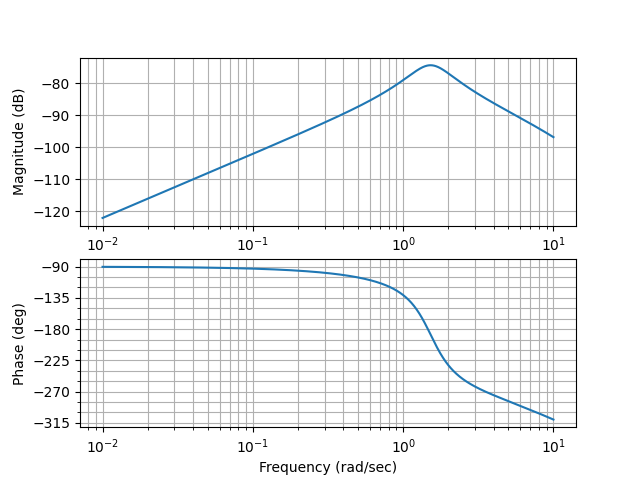

In [16]:
plt.figure()
mag, phase, omega = ct.bode(G_p, dB = True, omega_limits =  (0.01, 10))

# Sintonização do PID via ITAE

In [17]:
def ITAE(params, G_p):
    Kp, Ki, Kd = params
    C = ct.tf([Kd, Kp, Ki], [1, 0])
    G_cl = ct.feedback(C * G_p, 1)
    t, y = ct.step_response(G_cl)
    itae = np.trapz(t * np.abs(1 - y), t)
    return itae

In [18]:
# Estimativas iniciais para Kp, Ki e Kd
initial_params = [-20, -30, 0]

# Otimização
result = minimize(ITAE, initial_params, args=(G_p,), method='Nelder-Mead')
Kp, Ki, Kd = result.x

c:\Users\Eduardo\anaconda3\envs\control_env\lib\site-packages\scipy\linalg\_matfuncs.py:378: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
c:\Users\Eduardo\anaconda3\envs\control_env\lib\site-packages\scipy\linalg\_matfuncs.py:378: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
c:\Users\Eduardo\anaconda3\envs\control_env\lib\site-packages\control\timeresp.py:1051: RuntimeWarning: invalid value encountered in subtract
  Bd0 = expM[:n_states, n_states:n_states + n_inputs] - Bd1
c:\Users\Eduardo\anaconda3\envs\control_env\lib\site-packages\control\timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\Eduardo\anaconda3\envs\control_env\lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\Eduardo\anaconda3\envs\control_env\lib\site-packages\control\timeresp.py:1056: RuntimeWarning: overflow encountered in matmul

In [19]:
[Kp, Ki, Kd]

[-103278.96809252392, -1026090.6836209944, -37.18766988662352]

In [20]:
ITAE([Kp, Ki, Kd], G_p)

3.401950188067816e+22

In [21]:
# Controlador PID com parâmetros otimizados
s = ct.tf([1, 0], [1])
τ_d = Kd/Kp
N_d = 10000
G_c = Ki/s + Kp * (1 + (τ_d * s)/((τ_d * s)/N_d + 1))

# Função de transferência em malha fechada com controlador otimizado
T = ct.feedback(G_c * G_p, 1)
T

TransferFunction(array([ 6.87202621e+04,  1.90833431e+08,  1.89595558e+09, -8.86562838e-02]), array([ 3.60070115e-04,  1.00000343e+04,  9.52222439e+05,  1.11477090e+07,
        2.02657846e+08,  1.91954982e+09, -8.86562838e-02]))

In [22]:
T.poles()

array([-2.77723687e+07 +0.j        , -8.45552942e+01 +0.j        ,
       -4.57428500e-05+14.58854058j, -4.57428500e-05-14.58854058j,
       -1.06668181e+01 +0.j        ,  4.61859770e-11 +0.j        ])

In [23]:
# síntese de um pré-filtro
G_f = ct.tf([Ki], [Kd, Kp, Ki])
G_f

TransferFunction(array([-1026090.68362099]), array([-3.71876699e+01, -1.03278968e+05, -1.02609068e+06]))

In [24]:
# Função de transferência em malha fechada com controlador otimizado e pré-filtro
T_f = ct.series(G_f, T)
T_f

TransferFunction(array([-7.05132207e+10, -1.95812406e+14, -1.94542235e+15,  9.09693869e+04]), array([-1.33901686e-02, -3.71915162e+05, -1.06820453e+09, -1.09020050e+11,
       -2.13592683e+12, -3.24402371e+13, -4.06194452e+14, -1.96963219e+15,
        9.09693869e+04]))

In [25]:
T_f.poles()

array([-2.77723687e+07 +0.j        , -2.76726594e+03 +0.j        ,
       -8.45552942e+01 +0.j        , -4.57428497e-05+14.58854058j,
       -4.57428497e-05-14.58854058j, -1.06668181e+01 +0.j        ,
       -9.97093487e+00 +0.j        ,  4.61859770e-11 +0.j        ])

In [26]:
# FTs entre referência e entrada de controle (torque τ_φ)
Frτ = ct.feedback(G_c, G_p)
Frτ_f = ct.series(G_f, Frτ)

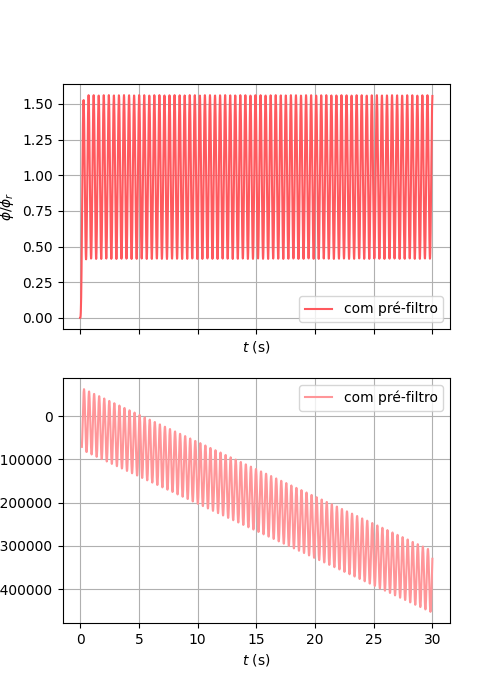

In [27]:
ts = np.linspace(0, 30, 2000)

#t, y = ct.step_response(T, ts)
#t, u = ct.step_response(Frτ, ts)

t, y_f = ct.step_response(T_f, ts)
t, u_f = ct.step_response(Frτ_f, ts)


fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

#state.plot(t, y, color=cp['blue'], label='sem pré-filtro')
state.plot(t, y_f, color=cp['red'], label='com pré-filtro')
state.set_ylabel(r'$\phi / \phi_r$ ')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

#control_input.plot(t[10:], u[10:], color=cp['lblue'],
                   #label='sem pré-filtro')
control_input.plot(t[10:], u_f[10:], color=cp['lred'],
                   label='com pré-filtro')
control_input.set_ylabel(r'$\tau_\phi/\phi_r$ (N m)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

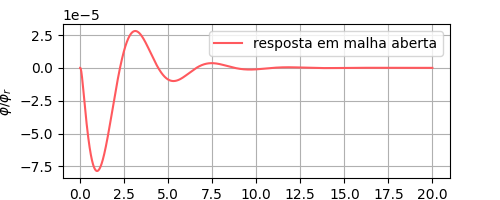

In [28]:
ts = np.linspace(0, 20, 2000)

#t, y = ct.step_response(T, ts)
#t, u = ct.step_response(Frτ, ts)

t, y_open = ct.step_response(G_p, ts)

fig, (state) = plt.subplots(
    1, 1, figsize=(5, 2), sharex=True)

state.plot(t, y_open, color=cp['red'], label='resposta em malha aberta')
state.set_ylabel(r'$\phi / \phi_r$ ')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

# Sintonização via ZN

In [29]:
K_c = sp.symbols('K_c')
s = sp.symbols('s')
p_CL = K_c * sp.Poly(G_p.num[0][0], s) + sp.Poly(G_p.den[0][0], s)
rh_CL = routh(p_CL)
rh_CL

Matrix([
[                                                                                                                                                                     1.0,                            1107.89882816501, 8.64019966684282e-12*K_c + 2359.42425472975],
[                                                                                                                                                         95.222203983581,    1182.44144496913 - 0.184774660440553*K_c,                                           0],
[                                                                                                                              0.00194045771585389*K_c + 1095.48112099691, 8.64019966684282e-12*K_c + 2359.42425472975,                                           0],
[                                                    (-0.000358547415546153*K_c**2 - 200.122674526627*K_c + 1070672.7019803)/(0.00194045771585389*K_c + 1095.48112099691),                                   

In [30]:
sp.solve(rh_CL[2, 0] > 0, K_c)

(-564547.793052449 < K_c) & (K_c < oo)

In [31]:
sp.solve(rh_CL[3, 0] > 0, K_c)

((-563448.182283635 < K_c) & (K_c < 5299.75937060761)) | ((-oo < K_c) & (K_c < -564547.793052449))

In [43]:
# ganho crítico (ultimate gain)
K_u = -563448
T_u = ct.feedback(K_u * G_p)
routh(sp.Poly(T_u.den[0][0], s))

Matrix([
[             1.0, 1107.89882816501, 2359.42424986144],
[ 95.222203983581, 105293.354320878,                0],
[ 2.1341019144676, 2359.42424986144,                0],
[17.4180213861576,                0,                0],
[2359.42424986144,                0,                0]])

In [44]:
cl_poles_u = T_u.poles()
cl_poles_u

array([-9.51997873e+01 +0.j        , -1.65292387e-06+33.25304143j,
       -1.65292387e-06-33.25304143j, -2.24133779e-02 +0.j        ])

In [45]:
# período com ganho crítico
P_u = 2*np.pi/np.imag(cl_poles_u[1])
P_u

0.18895069552601612

In [59]:
K_c_zn = 0.6 * K_u
τ_i = P_u/3
τ_d = P_u/3

N_d = 1000000
G_c_zn = K_c_zn * (1 + ct.tf([1], [τ_i, 0]) + ct.tf([τ_d, 0], [τ_d/N_d, 1]))
G_c_zn

TransferFunction(array([  -1341.09643083,  -21292.79959133, -338068.8       ]), array([3.96692948e-09, 6.29835652e-02, 0.00000000e+00]))

In [60]:
# FT em malha fechada
T_zn = ct.feedback(G_c_zn * G_p)
T_zn

TransferFunction(array([ 2.47800638e+02,  3.93436981e+03,  6.24665477e+04, -2.92098193e-06]), array([ 3.96692948e-09,  6.29839429e-02,  5.99743829e+00,  3.17580060e+02,
        4.00884420e+03,  6.26151527e+04, -2.92098193e-06]))

In [61]:
T_zn.poles()

array([-1.58771578e+07 +0.j        , -4.21881972e+01+45.72137314j,
       -4.21881972e+01-45.72137314j, -5.42278093e+00+15.08180393j,
       -5.42278093e+00-15.08180393j,  4.66497614e-11 +0.j        ])

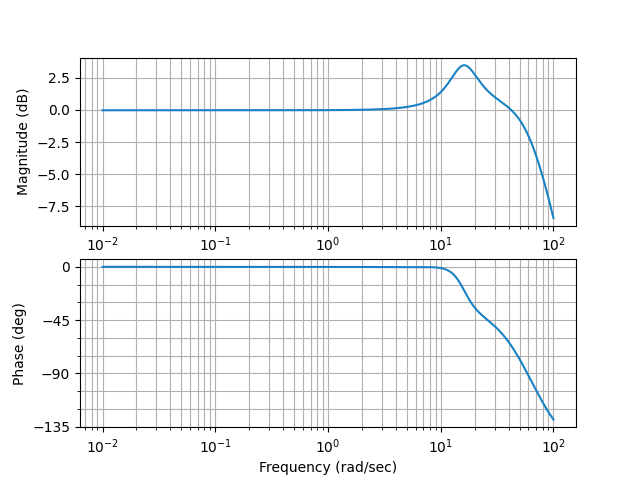

In [62]:
# diagrama de Bode em MF
plt.figure()
M_zn, φ_zn, omega_zn = ct.bode_plot(T_zn, 
                                omega=np.linspace(0.01, 100, 1001), 
                                color=cp['blue'], 
                                dB=True)

In [63]:
# FT entre referência e entrada de controle (torque τ_φ)
T_rτ_φ_zn = ct.feedback(G_c_zn, G_p)
T_rτ_φ_zn

TransferFunction(array([-1.34109643e+03, -1.48994957e+05, -3.85141527e+06, -5.73676920e+07,
       -4.02887732e+08, -4.49985308e+08, -7.97647726e+08]), array([ 3.96692948e-09,  6.29839429e-02,  5.99743829e+00,  3.17580060e+02,
        4.00884420e+03,  6.26151527e+04, -2.92098193e-06]))

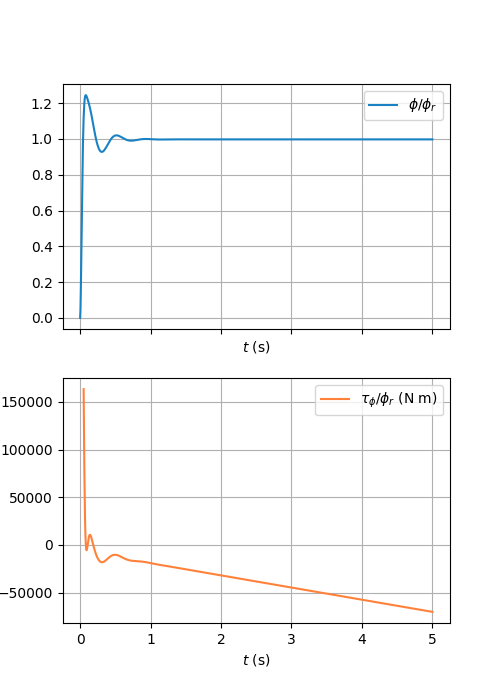

: 

In [64]:
# simulação do sistema em MF
ts = np.linspace(0, 5, 1000)

t, y = ct.step_response(T_zn, ts)
t, u = ct.step_response(T_rτ_φ_zn, ts)

fig, (state, control_input) = plt.subplots(
        2, 1, figsize=(5, 7), sharex=True)

state.plot(t, y,
            color=cp['blue'], label=r'$\phi / \phi_r$ ')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u[10:], color=cp['orange'],
                    label=r'$\tau_\phi/\phi_r$ (N m)')
# control_input.set_ylabel(r'(N m)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

# Root Locus Plot (Malha Aberta)

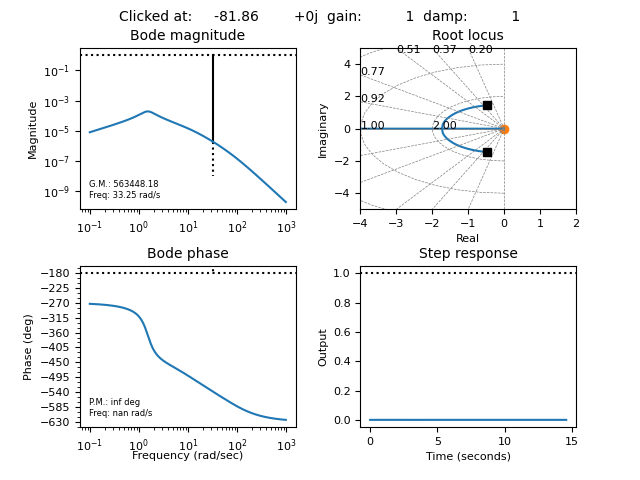

In [41]:
plt.ion()  # ativar o modo interativo
ct.sisotool(-G_p, xlim_rlocus=(-4, 2), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa